# <a id='top'>Covid-19 Data Analysis</a>

The purpose of this project is to clean, explore, and draw insights from the Johns Hopkins COVID-19 dataset ([source](https://data.world/associatedpress/johns-hopkins-coronavirus-case-tracker)) and the State and Policy Orders dataset ([source](https://catalog.data.gov/dataset/covid-19-state-and-county-policy-orders)). 

### Table of Contents

* 1 [data cleaning](#cleaning)<br>
    * 1.1 [Johns Hopkins](#jh)<br>
    * 1.2 [State and Policy Orders](#sp)<br> 
* 2 [data visualization](#viz)<br>
    * 2.1 [New Cases and Deaths](#2.1)<br>
    * 2.2 [Policy Data Overlay](#2.2)<br>
* 3 [correlation between cases and policies](#corr)<br>
    * 3.1 [Finding Correlations](#3.1)<br>
    * 3.2 [Evaluating Correlations](#3.2)<br>
    * 3.3 [Discussion](#3.3)<br>
    * 3.4 [Linear Regression](#3.4)<br>
* 4 [Conclusion](#4)<br>

### important notes: 
- When investigating the new case and death numbers by location, we will control for county / state population by reporting these figures per 100,000 people. I will be referring to these as the *normalized* values. 

### Associated links: 
- extended discussion of [data cleaning](https://nbviewer.jupyter.org/github/apalermo01/covid-19-data-analysis/blob/main/Covid-19%20data%20cleaning.ipynb)

- [github repo](https://github.com/apalermo01/covid-19-data-analysis)

# 0 Imports and configurations

In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [2]:
# configuration settings
%reset -f
%config InlineBackend.figure_format = 'svg'

# basics 
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import time

# visualizations
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import seaborn as sns
from ipywidgets import interact, Dropdown, SelectMultiple, fixed

# Linear regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# miscellaneous
import re
from tabulate import tabulate
from IPython.display import clear_output
import us
import requests

# 1 <a id='cleaning'>Data Cleaning</a>
[back to top](#top)

First, load each of the datasets. df = Johns Hopkins COVID-19 dataset, df2 = policy dataset. df is queried directly from dataworld, while the policy dataset is pulled from a local file.

**Load case and death data**

In [18]:
df = pd.read_csv('https://query.data.world/s/jbgdegbanosfmgly7etz2gxqsbhflk')

Use HTML source to get policy data 

In [19]:
html = requests.get("https://catalog.data.gov/dataset/covid-19-state-and-county-policy-orders").text
policy_file = html.split("a href=\"/dataset/covid-19-state-and-county-policy-orders")[1]\
    .split("<span>plotly</span>")[0]\
    .split("https://plot.ly/external/?url=")[1]\
    .split("\">")[0]
df2 = pd.read_csv(policy_file)

In [20]:
print("Johns Hopkins datset (raw): ")
df.head()

Johns Hopkins datset (raw): 


uid location_type  fips_code location_name        state        date  \
0  63072001        county    72001.0      Adjuntas  Puerto Rico  2020-01-22   
1  63072001        county    72001.0      Adjuntas  Puerto Rico  2020-01-23   
2  63072001        county    72001.0      Adjuntas  Puerto Rico  2020-01-24   
3  63072001        county    72001.0      Adjuntas  Puerto Rico  2020-01-25   
4  63072001        county    72001.0      Adjuntas  Puerto Rico  2020-01-26   

   total_population  cumulative_cases  cumulative_cases_per_100_000  \
0           18181.0                 0                           0.0   
1           18181.0                 0                           0.0   
2           18181.0                 0                           0.0   
3           18181.0                 0                           0.0   
4           18181.0                 0                           0.0   

   cumulative_deaths  cumulative_deaths_per_100_000  new_cases  new_deaths  \
0                  0                            0.0        NaN         NaN   
1                  0                            0.0        0.0         0.0   
2                  0                            0.0        0.0         0.0   
3                  0                            0.0        0.0         0.0   
4                  0                            0.0        0.0         0.0   

   new_cases_per_100_000  new_deaths_per_100_000  new_cases_7_day_rolling_avg  \
0                    NaN                     NaN                          NaN   
1                    0.0                     0.0                          NaN   
2                    0.0                     0.0                          NaN   
3                    0.0                     0.0                          NaN   
4                    0.0                     0.0                          NaN   

   new_deaths_7_day_rolling_avg  
0                           NaN  
1                           NaN  
2                           NaN  
3                           NaN  
4                           NaN

In [21]:
print("State and Policy orders dataset (raw): ")
df2.head()

State and Policy orders dataset (raw): 


state_id   county  fips_code policy_level        date  \
0       MS    Hinds    28049.0       county  2020-07-13   
1       AZ      NaN        NaN        state  2020-05-16   
2       OR      NaN        NaN        state  2020-05-15   
3       ND  Pembina    38067.0       county  2020-09-03   
4       OR     Lane    41039.0       county  2020-05-15   

                policy_type start_stop  \
0             Entertainment      start   
1         Houses of Worship      start   
2  Non-Essential Businesses      start   
3                   Phase 5      start   
4                 New Phase      start   

                                            comments  \
0  Policy_Details: Executive Order by Governor Ta...   
1  Policy_Details: All businesses are open but mu...   
2  Policy_Details: Currently open: Grocery stores...   
3  Policy_Details: - Most normal activity can res...   
4  Policy_Details: Gatherings up to 25 people all...   

                                              source  total_phases  
0  sip_submission_form: https://www.sos.ms.gov/co...           NaN  
1  sip_submission_form: https://azgovernor.gov/si...           NaN  
2  sip_submission_form: https://govstatus.egov.co...           NaN  
3  sip_submission_form: https://ndresponse.gov/si...           5.0  
4  sip_submission_form: https://www.eugene-or.gov...           NaN

## <a id='jh'>1.1 Johns Hopkins Covid-19 dataset</a>
[back to top](#top)

Shorten column names then inspect for nulls, unexpected data types, and invalid records.

In [22]:
df.rename(columns={
    'cumulative_cases_per_100_000'  : 'cumulative_cases_1e6', 
    'cumulative_deaths_per_100_000' : 'cumulative_deaths_1e6',
    'new_cases_per_100_000'         : 'new_cases_1e6', 
    'new_deaths_per_100_000'        : 'new_deaths_1e6', 
    'new_cases_7_day_rolling_avg'   : 'new_cases_7day', 
    'new_deaths_7_day_rolling_avg'  : 'new_deaths_7day'
    }, inplace=True)

Summary of expected datatypes and values: 

| column | details | accepted values |
|-----|------|--------|
| uid | Unique location identifier | numpy.int64
| location_type | type of location data | string
| fips_code | Federal Information Processing System code for each location | 5 digit integer
| location_name | location name | string
| state | state name | string
| date | date of record | datetime object
| total_population | county population | positive integer
| cumulative_cases | total number of covid cases | positive integer
| cumulative_cases_1e6 | normalized total covid cases | positive float
| cumulative_deaths | total number of covid deaths | positive integer
| cumulative_deaths_1e6 | normalized total covid deaths | positive float
| new_cases | number of new covid cases | positive integer
| new_deaths | number of new covid deaths | positive integer
| new_cases_1e6 | normalized number of new cases | positive float
| new_deaths_1e6 | normalized number of new deaths | positive float
| new_cases_7day | 7 day average of new cases | positive float
| new_deaths_7day | 7 day average of new deaths | positive float

Check the distribution of numerical fields, number of nulls in each column, and the datatypes present in each column. 

Define a custom function to evaluate nulls and data types (df.info() gives similar information but we want more detailed info on datatypes)

In [23]:
def eval_df(df):
    """Count the number of nulls and list datatypes present in each column in the input DataFrame."""
    
    table = []
    for col in df.columns: 
        table.append([col, df[col].isnull().sum(), set([type(i) for i in df[col].values])])
        
    print(tabulate(table, headers=["field", "num_nulls", "datatypes"]))

In [24]:
df.describe()

uid     fips_code  total_population  cumulative_cases  \
count  1.234320e+06  1.230620e+06      1.191400e+06      1.234320e+06   
mean   8.352961e+07  3.310136e+04      1.013323e+05      1.863005e+03   
std    3.206731e+06  1.861217e+04      3.260459e+05      1.054556e+04   
min    6.307200e+07  1.001000e+03      7.500000e+01      0.000000e+00   
25%    8.401811e+07  1.908500e+04      1.121425e+04      2.000000e+00   
50%    8.402921e+07  3.101800e+04      2.595050e+04      1.080000e+02   
75%    8.404612e+07  4.713300e+04      6.655225e+04      8.110000e+02   
max    8.410000e+07  9.999900e+04      1.009805e+07      1.079672e+06   

       cumulative_cases_1e6  cumulative_deaths  cumulative_deaths_1e6  \
count          1.191400e+06       1.234320e+06           1.191400e+06   
mean           1.802518e+03       4.566415e+01           3.541563e+01   
std            2.667836e+03       2.771262e+02           6.132807e+01   
min            0.000000e+00       0.000000e+00           0.000000e+00   
25%            2.213000e+01       0.000000e+00           0.000000e+00   
50%            4.920900e+02       1.000000e+00           6.200000e+00   
75%            2.597227e+03       1.600000e+01           4.653000e+01   
max            3.134991e+04       1.531400e+04           8.400200e+02   

          new_cases    new_deaths  new_cases_1e6  new_deaths_1e6  \
count  1.230984e+06  1.230984e+06   1.188180e+06    1.188180e+06   
mean   2.054212e+01  3.419817e-01   2.128263e+01    3.811569e-01   
std    1.431520e+02  5.366829e+00   5.560424e+01    2.596656e+00   
min   -7.590000e+03 -3.962000e+03  -5.975850e+03   -1.685400e+02   
25%    0.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00   
50%    1.000000e+00  0.000000e+00   2.930000e+00    0.000000e+00   
75%    9.000000e+00  0.000000e+00   2.367000e+01    0.000000e+00   
max    2.942300e+04  1.553000e+03   9.370100e+03    2.793300e+02   

       new_cases_7day  new_deaths_7day  
count    1.213835e+06     1.216897e+06  
mean     2.065242e+01     3.572515e-01  
std      1.301239e+02     2.541135e+00  
min      0.000000e+00     0.000000e+00  
25%      0.000000e+00     0.000000e+00  
50%      1.710000e+00     0.000000e+00  
75%      9.860000e+00     1.400000e-01  
max      1.607743e+04     2.445700e+02

In [25]:
eval_df(df)

field                    num_nulls  datatypes
---------------------  -----------  --------------------------------
uid                              0  {<class 'numpy.int64'>}
location_type                    0  {<class 'str'>}
fips_code                     3700  {<class 'numpy.float64'>}
location_name                  740  {<class 'str'>, <class 'float'>}
state                            0  {<class 'str'>}
date                             0  {<class 'str'>}
total_population             42920  {<class 'numpy.float64'>}
cumulative_cases                 0  {<class 'numpy.int64'>}
cumulative_cases_1e6         42920  {<class 'numpy.float64'>}
cumulative_deaths                0  {<class 'numpy.int64'>}
cumulative_deaths_1e6        42920  {<class 'numpy.float64'>}
new_cases                     3336  {<class 'numpy.float64'>}
new_deaths                    3336  {<class 'numpy.float64'>}
new_cases_1e6                46140  {<class 'numpy.float64'>}
new_deaths_1e6               46140  {<class 'n

While inspecting these tables a few issues become apparent: 

1) null values in most columns

2) some fields that should be integers are floats (total_population, new_cases, new_deaths)

3) some values for location_name are floats

4) negative values in new_cases, new_deaths, and their normalized equivalents 

We can likely eliminate some of these issues by throwing out some locations that are not a 'county' and locations not in the 50 states. 

In [26]:
df['location_type'].unique()

array(['county', 'special_exception', 'out_of_state',
       'count_unassigned_to_location'], dtype=object)

In [27]:
df = df.drop(df[df['location_type']!='county'].index) # drop location_types that are not counties

states = [elem.name for elem in us.states.STATES]     # get list of u.s. states
df = df.drop(df[~df['state'].isin(states)].index)     # drop anything not in one of the 50 states (also drops DC)

In [28]:
eval_df(df)

field                    num_nulls  datatypes
---------------------  -----------  -------------------------
uid                              0  {<class 'numpy.int64'>}
location_type                    0  {<class 'str'>}
fips_code                        0  {<class 'numpy.float64'>}
location_name                    0  {<class 'str'>}
state                            0  {<class 'str'>}
date                             0  {<class 'str'>}
total_population                 0  {<class 'numpy.float64'>}
cumulative_cases                 0  {<class 'numpy.int64'>}
cumulative_cases_1e6             0  {<class 'numpy.float64'>}
cumulative_deaths                0  {<class 'numpy.int64'>}
cumulative_deaths_1e6            0  {<class 'numpy.float64'>}
new_cases                     3141  {<class 'numpy.float64'>}
new_deaths                    3141  {<class 'numpy.float64'>}
new_cases_1e6                 3141  {<class 'numpy.float64'>}
new_deaths_1e6                3141  {<class 'numpy.float64'>}
new_case

Restricting locations had the effect of throwing out nulls in fips_code, location_name, total_poplulation, cumulative_cases_1e6, and cumulative_deaths_1e6. 

Make the locations more consistent by converting 'location_name' to 'county' (this will ensure consistency with the policy dataset) and make a new column with the combined county and state name. 

In [29]:
df['full_loc_name'] = df['location_name'] + ', ' + df['state']
df['location_name'] = df['location_name'].str.lower()

# re-order columns
cols = df.columns.tolist()
cols = cols[:6] + [cols[-1]] + cols[6:-1]
df = df[cols]

df.rename(columns={'location_name' : 'county'}, inplace=True)

Next, convert 'date' to datetime. 

In [30]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

We will now handle the negative and null values is the numerical columns. 

The nulls in new_cases(\_1e6) and new_deaths(\_1e6) all occur on 2020-01-22, the first day on which reporting occurs, so we can set these to zero.  

The negative values in these columns can also be set to zero. On the [disucssion page](https://data.world/associatedpress/johns-hopkins-coronavirus-case-tracker/discuss/johns-hopkins-coronavirus-case-tracker/zimsf5ki) for this dataset in dataworld  user nickyforester adressed the negative values in new_cases and new_deaths with the following comment: 

>We calculate the new_cases and new_deaths columns as the difference in the cumulative count from the previous day. Discrepancies do sometimes appear in the Johns Hopkins data where cumulative counts decrease from one day to the next. This can happen if state or local governments adjust their historical data.
Johns Hopkins works to fix these inconsistencies in their data. When they do, the timeseries won't show a decreasing cumulative count. Decreases in the cumulative count — or negative new case/death counts — should be treated as errors/inconsistencies, not as a correction from Johns Hopkins.

For those interested, I started an in-depth analysis on how these negative values are distributed in the data_cleaning notebook. 

Additionally, we will cast all these columns to integers. 

In [31]:
df.head()

uid location_type  fips_code   county    state       date  \
29600  84001001        county     1001.0  autauga  Alabama 2020-01-22   
29601  84001001        county     1001.0  autauga  Alabama 2020-01-23   
29602  84001001        county     1001.0  autauga  Alabama 2020-01-24   
29603  84001001        county     1001.0  autauga  Alabama 2020-01-25   
29604  84001001        county     1001.0  autauga  Alabama 2020-01-26   

          full_loc_name  total_population  cumulative_cases  \
29600  Autauga, Alabama           55200.0                 0   
29601  Autauga, Alabama           55200.0                 0   
29602  Autauga, Alabama           55200.0                 0   
29603  Autauga, Alabama           55200.0                 0   
29604  Autauga, Alabama           55200.0                 0   

       cumulative_cases_1e6  cumulative_deaths  cumulative_deaths_1e6  \
29600                   0.0                  0                    0.0   
29601                   0.0                  0                    0.0   
29602                   0.0                  0                    0.0   
29603                   0.0                  0                    0.0   
29604                   0.0                  0                    0.0   

       new_cases  new_deaths  new_cases_1e6  new_deaths_1e6  new_cases_7day  \
29600        NaN         NaN            NaN             NaN             NaN   
29601        0.0         0.0            0.0             0.0             NaN   
29602        0.0         0.0            0.0             0.0             NaN   
29603        0.0         0.0            0.0             0.0             NaN   
29604        0.0         0.0            0.0             0.0             NaN   

       new_deaths_7day  
29600              NaN  
29601              NaN  
29602              NaN  
29603              NaN  
29604              NaN

In [32]:
cols = ['new_cases', 'new_deaths', 'new_cases_1e6', 'new_deaths_1e6']

for col in cols: 
    df[col].fillna(value=0, inplace=True)
    df[col].clip(lower=0, inplace=True)

cols2 = ["fips_code", "total_population", "new_cases", "new_deaths"]
df[cols2] = df[cols2].astype(np.int64)

In the 7 day running averages, most of the nulls occur in the first few days, so set those to zero. 

There are additional nulls distributed throughout the dataset. Loop through these nulls and re-calculate the 7-day running average.

In [33]:
# Start timer. 
start = time.time()

# Set rolling averages to zero in the first few days of measurements.
df[['new_cases_7day', 'new_deaths_7day']] = df[['new_cases_7day', 'new_deaths_7day']].mask(
    (df['date'] < pd.to_datetime('2020-01-30', format='%Y-%m-%d')), df[['new_cases_7day', 'new_deaths_7day']].fillna(0)
    )

# Get dataframes where normalized new_cases and new_deaths are null
nulls_case7day = df[df['new_cases_7day' ].isnull()]
nulls_death7day = df[df['new_deaths_7day'].isnull()]

# Pre-define timedelta for efficiency. 
days_7 = timedelta(days=7)

# Prepare some outputs since this function will take a while. 
i = 0
num_elem = len(nulls_case7day)
msg = "Looping through nulls in new_cases_7day. Please be patient, this may take a while"
print(msg)

# Loop through nulls in new_cases_7day
for index, data in nulls_case7day.iterrows():
    
    # Output for inpatient people like me. 
    i += 1
    if i%10 == 0: 
        print(f"index: {i}/{num_elem}")
        
    if i%250 == 0: 
        clear_output()
        print(msg)
        print(f"index: {i}/{num_elem}")
    
    # Calculate rolling average at the datapoint of interest
    df.loc[index, ['new_cases_7day']] = np.sum((
        [df['new_cases'][(df['full_loc_name'] == data.full_loc_name) & 
        ((df['date'] <= data.date) & (df['date'] > data.date-days_7))].values])) / 7
    
# Reset output. 
clear_output()
print("Looping through nulls in new_deaths_7day. Please be patient, this may take a while")
i = 0
num_elem = len(nulls_death7day)

# Loop through nulls in new_deaths_7day
for index, data in nulls_death7day.iterrows():
    
    # Output status. 
    i += 1
    if i%10 == 0: 
        print(f"index: {i}/{num_elem}")
    
    # Calculate rolling average at datapoint of interest. 
    df.loc[index, ['new_deaths_7day']] = np.sum(([df['new_deaths'][
        (df['full_loc_name'] == data.full_loc_name) & 
        ((df['date'] <= data.date) & (df['date'] > data.date-days_7))].values])) / 7

# Output complete. 
clear_output()
print("done :)")
end = time.time()
print(f"time elapsed: {end-start}")

done :)
time elapsed: 88.65946650505066


Finally, make a few new columns with full location name (county, state) and normalized 7 day rolling averages. Convert location name to lowercase as well. 

In [34]:
df["new_cases_7day_1e6" ] = df['new_cases_7day' ] / (df['total_population'] / 1e5)
df["new_deaths_7day_1e6"] = df['new_deaths_7day'] / (df['total_population'] / 1e5)

Re-check the data to see if there are any missed issues

In [35]:
eval_df(df)

field                    num_nulls  datatypes
---------------------  -----------  ----------------------------
uid                              0  {<class 'numpy.int64'>}
location_type                    0  {<class 'str'>}
fips_code                        0  {<class 'numpy.int64'>}
county                           0  {<class 'str'>}
state                            0  {<class 'str'>}
date                             0  {<class 'numpy.datetime64'>}
full_loc_name                    0  {<class 'str'>}
total_population                 0  {<class 'numpy.int64'>}
cumulative_cases                 0  {<class 'numpy.int64'>}
cumulative_cases_1e6             0  {<class 'numpy.float64'>}
cumulative_deaths                0  {<class 'numpy.int64'>}
cumulative_deaths_1e6            0  {<class 'numpy.float64'>}
new_cases                        0  {<class 'numpy.int64'>}
new_deaths                       0  {<class 'numpy.int64'>}
new_cases_1e6                    0  {<class 'numpy.float64'>}
new_deaths

## 1.2 <a id='sp'>State and Policy Orders</a>
[back to top](#top)

Summary of expected datatypes and values: 

| column | details | accepted values |
|-----|------|--------|
| state_id | state name | string
| county | county name (this should be the same as county in the Johns Hopkins dataset) | string, county name for county level policies "statewide" for state policies
| fips_code | Federal Information Processing System code for each location | 5 digit integer
| policy_level | scope of policy | string, 'county' or 'state
| date | date of policy implementation | datetime object
| policy_type | brief description of policy classification | datetime object
| start_stop | whether this is the start of a restriction or lifting of a restriction | 'start' or 'stop' (string)
| comments | additional information | string
| source | source for policy info | string
| total_phases | total number of phases | positive integer

Since this is mostly text-based data, skip .describe()

In [36]:
eval_df(df2)

field           num_nulls  datatypes
------------  -----------  --------------------------------
state_id                0  {<class 'str'>}
county               1676  {<class 'str'>, <class 'float'>}
fips_code            1676  {<class 'numpy.float64'>}
policy_level            0  {<class 'str'>}
date                    0  {<class 'str'>}
policy_type             0  {<class 'str'>}
start_stop              0  {<class 'str'>}
comments                0  {<class 'str'>}
source                  0  {<class 'str'>}
total_phases         2937  {<class 'numpy.float64'>}


Data cleaning for the policy dataset is somewhat more straightforward. To start: 

1) drop policies not implemented in the 50 states

2) convert state abbreviations to the full name 

3) re-name 'state_id' to 'state'

4) drop total_phases since we won't be using it 

5) nulls in 'county' are statewide policies, so fill nulls with 'statewide'

6) convert 'county' to lowercase

7) convert 'date' from int to datetime

In [37]:
df2.head()

state_id   county  fips_code policy_level        date  \
0       MS    Hinds    28049.0       county  2020-07-13   
1       AZ      NaN        NaN        state  2020-05-16   
2       OR      NaN        NaN        state  2020-05-15   
3       ND  Pembina    38067.0       county  2020-09-03   
4       OR     Lane    41039.0       county  2020-05-15   

                policy_type start_stop  \
0             Entertainment      start   
1         Houses of Worship      start   
2  Non-Essential Businesses      start   
3                   Phase 5      start   
4                 New Phase      start   

                                            comments  \
0  Policy_Details: Executive Order by Governor Ta...   
1  Policy_Details: All businesses are open but mu...   
2  Policy_Details: Currently open: Grocery stores...   
3  Policy_Details: - Most normal activity can res...   
4  Policy_Details: Gatherings up to 25 people all...   

                                              source  total_phases  
0  sip_submission_form: https://www.sos.ms.gov/co...           NaN  
1  sip_submission_form: https://azgovernor.gov/si...           NaN  
2  sip_submission_form: https://govstatus.egov.co...           NaN  
3  sip_submission_form: https://ndresponse.gov/si...           5.0  
4  sip_submission_form: https://www.eugene-or.gov...           NaN

In [38]:
abbr = [elem.abbr for elem in us.states.STATES]

df2 = df2.drop(df2[~df2['state_id'].isin(abbr)].index)                     
df2.replace(to_replace=us.states.mapping('abbr', 'name'), inplace=True)    
df2.rename(columns={'state_id' : 'state'}, inplace=True)                   
df2.drop('total_phases', axis=1, inplace=True)                             
df2['county'].fillna(value='statewide', inplace=True)                      
df2['county'] = df2['county'].str.lower()                                  
df2.loc[:, 'date'] = '2020' + df2['date'].str[4:] # some formatting issues in 'date': 0020 instead of 2020
df2['date'] = pd.to_datetime(df2['date'], format='%Y-%m-%d')          

There are several mismatches between 'county' in df2 and 'location_name' in df. All of these end with a modifier- most of them end in 'county' (e.g. 'bronx county') and a few end in 'municipality' and 'borough'. We'll simply strip these off in df2. 

In [39]:
county_match  = re.compile(" county$")
munici_match  = re.compile(" municipality$")
Borough_match = re.compile(" borough$")

df2['county'].replace(to_replace=county_match,  value='', inplace=True)
df2['county'].replace(to_replace=munici_match,  value='', inplace=True)
df2['county'].replace(to_replace=Borough_match, value='', inplace=True)

Nulls in fips_code relate to statewide polices, so replace the nulls with the 2 digit fips code for the state 

In [40]:
for index, data in df2.iterrows(): 
    if data.policy_level == 'state': 
        df2.loc[index, 'fips_code'] = np.int64(us.states.lookup(data.state).fips)

Convert fips_code to integers

In [41]:
df2['fips_code'] = df2['fips_code'].astype(np.int64)

Examine all the policy types in this dataset.

In [42]:
print(np.sort((df2['policy_type'].unique())))

['Agriculture' 'Allow Audio Only Telehealth'
 'Allow Expand Medicaid Telehealth Coverage'
 'Alternative Care Facilities ' 'Bars' 'Childcare (K-12)'
 'Colleges & Universities' 'Construction' 'Day Care'
 'Day camps/overnight camps' 'Education' 'Election' 'Entertainment'
 'Executive Order' 'Food and Drink' 'Froze Mortgage Payments' 'Gatherings'
 'Graduation' 'Graduation Ceremony guidelines' 'Gyms' 'Health Risk Status'
 'Houses of Worship'
 'Mandate Face Mask Use By All Individuals In Public Facing Businesses'
 'Mandate Face Mask Use By All Individuals In Public Spaces'
 'Manufacturing' 'Mask Requirement' 'Medical'
 'Modify Medicaid Requirements With 1135 Waivers Date Of CMS Approval'
 'New Phase' 'Non-Essential Businesses' 'Nursing Home Visitations'
 'Nursing Homes' 'Order Freezing Utility Shut Offs'
 'Outdoor and Recreation' 'Personal Care' 'Phase 1' 'Phase 2' 'Phase 2, 3'
 'Phase 3' 'Phase 3 Step 2' 'Phase 4' 'Phase 5' 'Public Gatherings'
 'Public Health Advisory System' 'Quarantine'
 '

drop vague / unrelated policies

In [43]:
policies_drop = ['New Phase', 'Phase 1', 'Phase 2', 'Phase 2, 3', 'Phase 3', 'Phase 3 Step 2', 'Phase 4', 'Phase 5']
print(f"dropping policies: {policies_drop}")
df2 = df2.drop(df2[df2['policy_type'].isin(policies_drop)].index)

dropping policies: ['New Phase', 'Phase 1', 'Phase 2', 'Phase 2, 3', 'Phase 3', 'Phase 3 Step 2', 'Phase 4', 'Phase 5']


In [44]:
df2['policy_type'].sort_values().unique()

['Agriculture' 'Allow Audio Only Telehealth'
 'Allow Expand Medicaid Telehealth Coverage'
 'Alternative Care Facilities ' 'Bars' 'Childcare (K-12)'
 'Colleges & Universities' 'Construction' 'Day Care'
 'Day camps/overnight camps' 'Education' 'Election' 'Entertainment'
 'Executive Order' 'Food and Drink' 'Froze Mortgage Payments' 'Gatherings'
 'Graduation' 'Graduation Ceremony guidelines' 'Gyms' 'Health Risk Status'
 'Houses of Worship'
 'Mandate Face Mask Use By All Individuals In Public Facing Businesses'
 'Mandate Face Mask Use By All Individuals In Public Spaces'
 'Manufacturing' 'Mask Requirement' 'Medical'
 'Modify Medicaid Requirements With 1135 Waivers Date Of CMS Approval'
 'Non-Essential Businesses' 'Nursing Home Visitations' 'Nursing Homes'
 'Order Freezing Utility Shut Offs' 'Outdoor and Recreation'
 'Personal Care' 'Public Gatherings' 'Public Health Advisory System'
 'Quarantine' 'Renter Grace Period Or Use Of Security Deposit To Pay Rent'
 'Reopened ACA Enrollment Using a 

Some of these names are a bit too long. Rename any policy type longer than 40 characters, then convert all of them to lowercase

In [48]:
policy_replacements_dict = {
    'Stop Initiation Of Evictions Overall Or Due To Covid Related Issues'  : 'Stop Initiation Of Evictions',
    'Modify Medicaid Requirements With 1135 Waivers Date Of CMS Approval'  : 'Modify Medicaid Requirements', 
    'Stop Enforcement Of Evictions Overall Or Due To Covid Related Issues' : 'Stop Enforcement Of Evictions', 
    'Mandate Face Mask Use By All Individuals In Public Facing Businesses' : 'Mandate Face Masks In Businesses', 
    'Mandate Face Mask Use By All Individuals In Public Spaces'            : 'Mandate Face Masks In Public Spaces', 
    'Reopened ACA Enrollment Using a Special Enrollment Period'            : 'ACA Special Enrollment Period', 
    'Suspended Elective Medical Dental Procedures'                         : 'Suspend Elective Dental Procedures', 
    'Allow Expand Medicaid Telehealth Coverage'                            : 'Expand Medicaid Telehealth Coverage', 
    'Renter Grace Period Or Use Of Security Deposit To Pay Rent'           : 'Grace Period / Security Deposit for Rent'
}

for key in policy_replacements_dict.keys():
    df2['policy_type'].replace(to_replace=key, value=policy_replacements_dict[key], inplace=True)
    
df2['policy_type'] = df2['policy_type'].str.lower()

df2['policy_type'].sort_values().unique()

array(['aca special enrollment period', 'agriculture',
       'allow audio only telehealth', 'alternative care facilities ',
       'bars', 'childcare (k-12)', 'colleges & universities',
       'construction', 'day camps/overnight camps', 'day care',
       'education', 'election', 'entertainment', 'executive order',
       'expand medicaid telehealth coverage', 'food and drink',
       'froze mortgage payments', 'gatherings',
       'grace period / security deposit for rent', 'graduation',
       'graduation ceremony guidelines', 'gyms', 'health risk status',
       'higher education', 'houses of worship', 'libraries',
       'mandate face masks in businesses',
       'mandate face masks in public spaces', 'manufacturing',
       'mask requirement', 'medical', 'modify medicaid requirements',
       'museums', 'non-essential businesses', 'nursing home visitations',
       'nursing homes', 'order freezing utility shut offs',
       'outdoor and recreation', 'personal care', 'public gath

Drop policies that were enacted before the first date in the case dataset and policies scheduled in the future

In [49]:
df2 = df2.drop(df2[(df2['date'] < min(df['date'])) | (df2['date'] > datetime.today())].index)

Final check: 

In [50]:
eval_df(df2)

field           num_nulls  datatypes
------------  -----------  ----------------------------
state                   0  {<class 'str'>}
county                  0  {<class 'str'>}
fips_code               0  {<class 'numpy.int64'>}
policy_level            0  {<class 'str'>}
date                    0  {<class 'numpy.datetime64'>}
policy_type             0  {<class 'str'>}
start_stop              0  {<class 'str'>}
comments                0  {<class 'str'>}
source                  0  {<class 'str'>}


Finally, export these datasets to csv files to build the associated dashboard in tableau

In [51]:
df.to_csv("case_data_clean.csv")
df2.to_csv("policy_data_clean.csv")

# 2 <a id='viz'>Data visualizations</a>
[back to top](#top)

# 2.1 <a id='2.1'>New cases and deaths</a>
[back to top](#top)

Plot cases and deaths at the county, state, and national levels.  

In [52]:
def get_cases(level="county", county="orange", state="California", df=df):
    
    """ Return the new_case and new_death numbers at the given level of aggregation (county, state, or national). 
    
    Parameters
    ----------
    level : {'county', 'state', 'national'}
        If county, returns a DataFrame filtered to a specific county (default). 
        If state, aggregates the DataFrame to the state level. 
        If national, or any other input, returns the DataFrame aggregated to the national level. 
    county : string 
        desired county
    state : string 
        desired state
    df : pandas DataFrame 
        DataFrame to use, df by default
    
    Returns 
    ----------
    DataFrame
        case_data filtered to a specific county or aggregated to the state / national level with index=date
    """
    # return county level data
    if level == "county":
        return_df = df[(df["county"] == county) & (df["state"] == state)].set_index("date")[['new_cases_1e6', 
                                                                                             'new_deaths_1e6', 
                                                                                             'new_cases_7day_1e6', 
                                                                                             'new_deaths_7day_1e6',
                                                                                            ]]
        
        return return_df
    
    # If this is filtered at the state level, filter df to desired state. Otherwise, return national-level data.
    if level == "state": 
        df = df[df['state'] == state]

    # Reindex on location name.
    df = df.set_index(["full_loc_name"])
    
    # Get a list of all dates.
    all_dates = df['date'].unique()

    # Get the total population from the county populations.
    total_population =  sum([(pops / 1e5) for pops in df[df['date'] == all_dates[0]]['total_population']]) 
    
    # Add up the case and death #s that have the same date.
    new_cases       = [sum([(county_cases / total_population) 
                              for county_cases in df[df['date'] == dates]['new_cases_1e6']]) 
                              for dates in all_dates]

    new_deaths      = [sum([(county_cases / total_population) 
                              for county_cases in df[df['date'] == dates]['new_deaths_1e6']]) 
                              for dates in all_dates]

    new_cases_7day  = [sum([(county_cases / total_population) 
                              for county_cases in df[df['date'] == dates]['new_cases_7day_1e6']]) 
                              for dates in all_dates]

    new_deaths_7day = [sum([(county_cases / total_population) 
                              for county_cases in df[df['date'] == dates]['new_deaths_7day_1e6']]) 
                              for dates in all_dates]


    return_df = pd.DataFrame(data={'date'               : all_dates,
                                   'new_cases_1e6'      : new_cases, 
                                   'new_deaths_1e6'     : new_deaths,
                                   'new_cases_7day_1e6' : new_cases_7day,
                                   'new_deaths_7day_1e6': new_deaths_7day
                                   }).set_index(["date"]) 
    return return_df

In [53]:
def plot_cases(level="county", county="orange", state="California", df=df, fade=0.75, style="whitegrid", ax=None, fig=None):
    
    """ A function which plots the COVID-19 case/death data and 7 day average.
    
    Parameters
    ---------- 
    level : {'county', 'state', 'national'}
        Value to pass to get_cases()
    county : string 
        desired county
    state : string 
        desired state
    df : pandas DataFrame 
        DataFrame to use, df by default
    style : string
        Seaborn plot style (default: "whitegrid")
    fade : float
        level of transparency for new_cases_1e6 and new_deaths_1e6 (default: 0.75)
        
    Returns 
    ----------
    matplotlib.figure.Figure
    ndarray containing the two axis handles
    pandas DataFrame
    """
    
    # Get the data. 
    cases = get_cases(level, county, state, df)
        
    # Set up plots. 
    if ax is None: 
        fig, ax = plt.subplots(2, 1, figsize=(10,5), sharex=True);
    plt.subplots_adjust(hspace=0.02)
    sns.set_style(style)
    
    # Plot cases.
    cases.plot(
        color=[f'{fade}', 'k'],
        y=["new_cases_1e6","new_cases_7day_1e6"],
        label=["Cases per capita", "7-day average"],
        ax=ax[0]
        );

    # Plot deaths. 
    cases.plot(
        color=[f'{fade}', 'k'],
        y=["new_deaths_1e6","new_deaths_7day_1e6"],
        label=["Deaths per capita", "7-day average"],
        ax=ax[1]
        );
    
    # Format axis labels. 
    ax[0].set_ylabel("cases per 100,000")
    ax[1].set_ylabel("deaths per 100,000")
    
    # Set plot title based on level of aggregeation (county, state, or national)
    if level == "county":
        ax[0].set_title(f"New COVID-19 cases and deaths per 100,000 in {county} County, {state}");
    elif level == "state": 
        ax[0].set_title(f"New COVID-19 cases and deaths per 100,000 in {state}");
    else: 
        ax[0].set_title("New COVID-19 cases and deaths per 100,000 in the United States")
    
    
    return fig, ax, cases

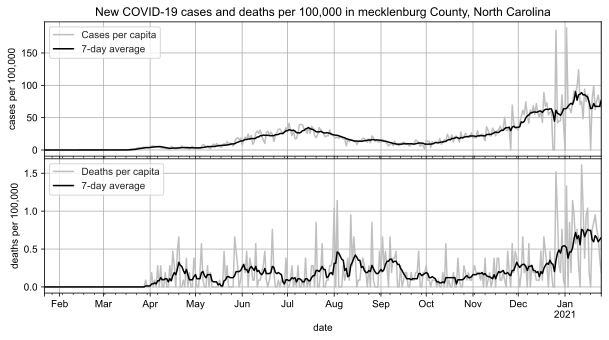

In [54]:
plot_cases(level="county", county="mecklenburg", state="North Carolina");

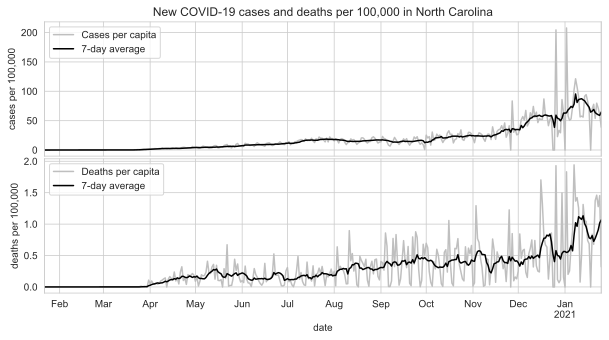

In [55]:
plot_cases(level="state", state="North Carolina");

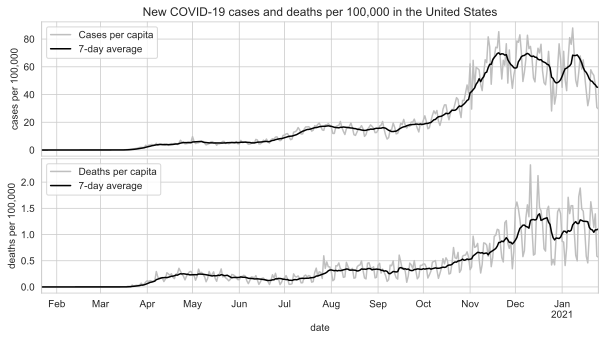

In [56]:
plot_cases(level="national");

# 2.2 <a id='2.2'>Policy data overlay</a>
[back to top](#top)<br>
First, get the policy data for a specific county at the state level, county level, or both. Then, make a plot that overlays policy enactments and case / death numbers with a few selected policies. 

In [57]:
def get_policy_data(state="California", county="statewide", state_policies=True, county_policies=True, df=df2):
   
    """Get the policy data at county level, state level, or both.  

    Parameters
    ----------
    state : string 
        selected state
    county : string
        selected county
    state_policies : boolean 
        include policies at the state level (default: True)
    county_policies : boolean 
        include policies at the county level (default: True)
    
    Returns
    ---------- 
    filtered DataFrame
    """
    # state AND county policies
    if state_policies and county_policies:

        return df[(df['state'] == state) &
                  ((df["county"] == county) | (df["county"] == "statewide"))]
    
    # state policies only
    elif state_policies and not county_policies: 
        return df[ (df['state'] == state) & (df["county"] == "statewide")]
    
    # county policies only
    else:  
         return df[ (df['state'] == state) & (df["county"] == county)]

In [60]:
def plot_cases_and_policies(
        county, state, 
        colors=sns.color_palette()[:],  
        policies=[
            "mandate face masks in public spaces", 
            "mandate face masks in businesses", 
            "shelter in place", 
            "state of emergency"],
                           
        labels=["face mask mandate (public spaces)", 
            "face mask mandate (businesses)", 
            "shelter in place", 
            "state of emergency"],
    ):

    
    """Plot the cases overlayed with the policies. 
    
    Parameters
    ---------- 
    county : string 
        county of interest
    state : string
        state of interest
    policies : array-like
        policies to plot (default: face mask mandates in public spaces and businesses, shelter in place, 
        and state of emergency)
    colors : array-like
        line colors for respective policies (in order) (default: k, b, r, g)
    labels : array-like 
        legend labels for the selected policies (default: "face mask mandate (public spaces)", 
        "face mask mandate (businesses)", "shelter in place", and "state of emergency")
    style : string 
        sns plot style (whitegrid by default, dark styles not recommended)
    fade : float
        level of transparency for new_cases_1e6 and new_deaths_1e6 (default: 0.75)
    
    The marks for policies are aligned with the 7 day average, using colors to indicate policy types, endcaps for 
    state (diamond) or county (circle), and linestyle to distinguish the start (solid line) or stop (dotted line) of a 
    policy. 
    
    Returns
    ----------
    ndarray containing the two axis handles used for plotting
    """

    
    # Plot case / death data.
    plt.figure();
    fig, ax, df = plot_cases(level="county", county=county, state=state);

    # Get the policy data for the selected state and county.
    policy_data = get_policy_data(state, county);

    # Set a solid line to be the start of a policy and a dashed line to be the end.
    styles_start_stop = {
        "start" : '-', 
        "stop" : ':'
    }

    # Set color codes for selected policies.
    styles_policy_type = {policies[i] : colors[i] for i in range(len(policies))}
    
    # Set labels for legend.
    legend_policy_labels = {policies[i] : labels[i] for i in range(len(policies))}
    
    # Define plot parameters. 
    legend_position = (1, 1) 
    line_split = 0                
    mark_length = 0.2
    plot_policies = policy_data[policy_data['policy_type'].isin(policies)]
    labels = []
    
    # Loop through both axes. 
    for i in range(2):
        
        # Expand y axis to get some extra room on the bottom.
        ax[i].set_ylim(-max(ax[i].lines[0].get_ydata())*(0.15))
        
        # Loop through policies.
        for index, row in plot_policies.sort_values(by="date").iterrows():

            # Get the y-positional coordinate for the line on the selected day (between 0 and 1). 
            if i == 0: 
                center = df[df.index == row.date]['new_cases_7day_1e6'].values[0]
            else: 
                center = df[df.index == row.date]['new_deaths_7day_1e6'].values[0]
            
            # Calculate where to position the line horizontally.  
            days_serial = (row.date - pd.Timestamp(year=1970, month=1, day=1)).days
            cent_coord = ax[i].transLimits.transform((days_serial, center))[1]

            # loop through all the policies enacted on a given day. Normally, this is 1, but we want to visualize all the
            # policies enacted on the same day, so we're goint to split the line accordingly.

            num_policies = plot_policies['date'].value_counts()[row.date]
            
            # Split the mark if there are multiple policies enacted on the same day.
            if num_policies > 1: 
                hmin = (cent_coord - (mark_length/2)) + line_split * (mark_length/num_policies)
                hmax = (cent_coord + (mark_length/2)) - \
                    (mark_length/num_policies) + ((line_split*mark_length) / num_policies)
                line_split += 1

            if num_policies == 1:
                hmin = (cent_coord - (mark_length/2))
                hmax = (cent_coord + (mark_length/2))
                line_split=0
                
            # Plot the mark.
            line = ax[i].axvline(x         = row.date,
                                 linestyle = styles_start_stop[row.start_stop], 
                                 color     = styles_policy_type[row.policy_type], 
                                 lw        = 2,
                                 ymin      = hmin, 
                                 ymax      = hmax,
                                )

            # Add the policy to the legend if it's not already in the list of labels
            if (row.policy_type not in labels): 
                labels.append(row.policy_type);
                
            # Set markers for state or county policies. 
            if row.policy_level == "state":
                line.set_marker('d')
                
            else: 
                line.set_marker('o')
                
            ax[i].legend(loc="upper left")
        
    # Make the legend. 
    legend_lines = []
    
    # Use square boxes to denote colors for policy types. 
    [legend_lines.append(Line2D([0], [0], marker="s", markersize=15, color='w', 
                           markerfacecolor=styles_policy_type[policy], lw=3, label=policy)) for policy in labels]
    
    # Draw a diamond to indicate a state policy. 
    legend_lines.append(Line2D([0], [0], marker="d", markersize=10, color='w', 
                           markerfacecolor='w', markeredgecolor='k', markeredgewidth=1.5, lw=3, label="state policy"))
    
    # Draw a circle to indicate a county policy. 
    legend_lines.append(Line2D([0], [0], marker="o", markersize=10, color='w', 
                           markerfacecolor='w', markeredgecolor='k', markeredgewidth=1.5, lw=3, label="county policy"))
    
    # Use a solid line for policy start, dotted line for policy stop. 
    legend_lines.append(Line2D([0], [0], linestyle='-', color='k', lw=3, label = "policy start"))
    legend_lines.append(Line2D([0], [0], linestyle=':', color='k', lw=3, label = "policy stop"))
                   
     
    # Finally, draw the legend. 
    leg1 = ax[0].legend(loc='upper left')
    leg2 = ax[0].legend(handles=legend_lines, bbox_to_anchor=legend_position)
    ax[0].add_artist(leg1);
            
    return ax

<Figure size 432x288 with 0 Axes>

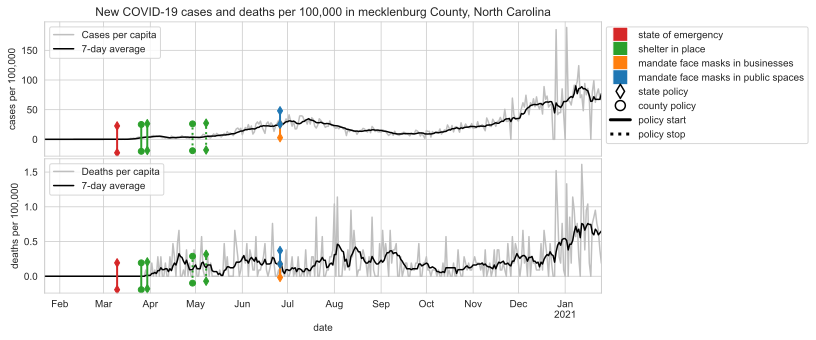

In [61]:
plot_cases_and_policies(county="mecklenburg", state="North Carolina");

# 3. <a id='corr'>Connecting case numbers and covid policies</a>
[back to top](#top)<br>

# 3.1 <a id='3.1'>Finding Correlations</a>
[back to top](#top)<br>

Find the correlation between case / death numbers and policies.

First, calculate the change in the number of new cases at the point of a policy implementation and 14 days afterward. Additionally, find the curvature (i.e. 'acceleration') after a given policy implementation. 

In [62]:
def calculate_deltas(measure_period=14, filtered_policies=None, case_df=df, policy_df=df2): 
    """For every policy implementation at the state and county level, calculate the change in case and death numbers. 
    
    Parameters
    ---------- 
    measure_period : int
        time to wait (in days) before measuring a change in new case or death numbers (14 by default)
    filtered_policies : array-like 
        specify policies to select (defaul: None- calulate deltas for all policies)
    case_df : pandas DataFrame
        DataFrame with case / death information (default: df)
    policy_df : pandas DataFrame
        DataFrame with police information (default: df2)
    
    Returns
    ----------  
    A copy of the covid policies df (df2) with 2 appended columns for the change in case and death numbers. 
    """
    
    # Initialize wait period before measurement.
    wait_period = timedelta(days=measure_period)
    day_1 = timedelta(days=1)
    
    def sub_calc_deltas(ser, date, wait=wait_period): 
        """Wrap repeated calculations in a sub function to avoid repetition."""
        day_1 = timedelta(days=1)
    
        start      = ser[ser.index==date].values[0]
        start_1day = ser[ser.index==date+day_1].values[0]
        
        end        = ser[ser.index==date+wait].values[0]
        end_1day   = ser[ser.index==date+wait+day_1].values[0]
        
        return [start, start_1day, end, end_1day]
    
    # If there we are only examining select policies, then filter those out.
    if filtered_policies is not None: 
        policy_df = policy_df.loc[policy_df['policy_type'].isin(filtered_policies)]
        
    correlated_df = policy_df.copy()
    
    # Initially fill the delta column with nan.
    correlated_df.loc[:, f"case_{measure_period}_day_delta"] = np.nan
    correlated_df.loc[:, f"case_{measure_period}_day_accel"] = np.nan
    correlated_df.loc[:, f"death_{measure_period}_day_delta"] = np.nan
    correlated_df.loc[:, f"death_{measure_period}_day_accel"] = np.nan
    
    # Load all state-aggregated datasets into a dictionary. We expect to need all 50 states so let's take the time to aggregate
    # the state data now so we don't need to do it repeatedly in the loop. 
    
    state_cases_dict = dict()
    for state in [elem.name for elem in us.states.STATES]: 
        state_cases_dict[state]=get_cases(level="state", state=state);
    
    case_df = case_df.set_index('date')
    total_policies = len(policy_df)
    
    for index, data in policy_df.iterrows(): 
          
        # If this is a state-level policy, then we already have the DataFrame to use. 
        if data.policy_level == 'state': 
            state_df = state_cases_dict[data.state]
            ser_cases = state_df['new_cases_7day_1e6' ]
            ser_deaths = state_df['new_deaths_7day_1e6']
        
        # This must be a county level policy- filter the appropriate data. 
        else:
            ser_cases = case_df['new_cases_7day_1e6' ][case_df['fips_code'] == data.fips_code]
            ser_deaths = case_df['new_deaths_7day_1e6'][case_df['fips_code'] == data.fips_code]
        
        # Get the case and death numbers at the appropriate days. 
        c11, c12, c21, c22 = sub_calc_deltas(ser_cases, date=data.date)
        d11, d12, d21, d22 = sub_calc_deltas(ser_deaths, date=data.date)
           
        # Calculate the difference in new cases at the selected dates. 
        correlated_df.at[index, f"case_{measure_period}_day_delta"] = c21 - c11
        correlated_df.at[index, f"death_{measure_period}_day_delta"] = d21 - d11
        
        # Calculate the change in curvature (aka acceleration) of the case / death plots at policy implementation and
        # measure_period days afterwards. 
        
        correlated_df.at[index, f"case_{measure_period}_day_accel"] = ((c12-c11) - (c21-c22)) / measure_period
        correlated_df.at[index, f"death_{measure_period}_day_accel"] = ((d12-d11) - (d21-d22)) / measure_period    
    
    
    return correlated_df

In [63]:
policy_deltas = calculate_deltas()
policy_deltas.head()

state     county  fips_code policy_level       date  \
0  Mississippi      hinds      28049       county 2020-07-13   
1      Arizona  statewide          4        state 2020-05-16   
2       Oregon  statewide         41        state 2020-05-15   
5  Connecticut  statewide          9        state 2020-03-16   
6     Michigan  statewide         26        state 2020-03-16   

                policy_type start_stop  \
0             entertainment      start   
1         houses of worship      start   
2  non-essential businesses      start   
5                      gyms      start   
6                      gyms      start   

                                            comments  \
0  Policy_Details: Executive Order by Governor Ta...   
1  Policy_Details: All businesses are open but mu...   
2  Policy_Details: Currently open: Grocery stores...   
5  Other measures and details for this policy inc...   
6  Other measures and details for this policy inc...   

                                              source  case_14_day_delta  \
0  sip_submission_form: https://www.sos.ms.gov/co...          25.292215   
1  sip_submission_form: https://azgovernor.gov/si...           1.181946   
2  sip_submission_form: https://govstatus.egov.co...          -0.152593   
5                  BU COVID-19 State Policy Database           1.213029   
6                  BU COVID-19 State Policy Database           1.472359   

   case_14_day_accel  death_14_day_delta  death_14_day_accel  
0          -0.105470           -0.119947            0.038111  
1           0.023800           -0.004997            0.000156  
2          -0.002194           -0.021983            0.000098  
5           0.016448            0.019440            0.001281  
6           0.019070            0.060381            0.001331

Next, calculate the average deltas for each kind of policy implementation. 


In [201]:
def calc_delta_stats(deltas, measure_period=14, min_samples=10):
    """Take the deltas calculated with each policy and calculate the average and sd. 
    Parameters
    ---------- 
    deltas : pandas DataFrame 
        dataframe of policy deltas on which to do the calculations
    measure_period : int 
        time to wait (in days) before measuring a change in new case or death numbers (14 by default)
    min_samples : int 
        minimum number of samples that a policy must have for reporting of average and std (default: 10)
    
    Returns
    ----------   
    A dataframe with a record for the start/stop of each policy type and the average / std of the change in 
    case / death numbers measure_period days after implementation
    """
    # Generate a new list of policy types differentiating between start and stop. 
    policy_types = ([elem + " - start" for elem in deltas['policy_type'].unique()]  
                    + [elem + " - stop"  for elem in deltas['policy_type'].unique()])
    
    # Initialize empty arrays for the associated statistics.
    case_avg, death_avg, case_std, death_std, num_samples = [], [], [], [], []
    case_accel_avg, death_accel_avg, case_accel_std, death_accel_std = [], [], [], []
    
    # Loop through all the policy types.
    for policy in policy_types:
        
        # Determine whether this policy is the beginning or end.  
        if policy.endswith("stop"):
            len_index = -7
            start_stop = "stop"
        else: 
            len_index = -8
            start_stop = "start"
        
        # Get arrays of all the deltas for each type of policy 
        case_data  = deltas[(deltas['policy_type'] == policy[:len_index]) & 
                            (deltas['start_stop'] == start_stop)][f'case_{measure_period}_day_delta']

        death_data = deltas[(deltas['policy_type'] == policy[:len_index]) & 
                            (deltas['start_stop'] == start_stop)][f'death_{measure_period}_day_delta']

        case_accel_data = deltas[(deltas['policy_type'] == policy[:len_index]) & 
                                 (deltas['start_stop'] == start_stop)][f'case_{measure_period}_day_accel']
         
        death_accel_data = deltas[(deltas['policy_type'] == policy[:len_index]) & 
                                  (deltas['start_stop'] == start_stop)][f'death_{measure_period}_day_accel']

        num_samples.append(len(case_data))
        
        # Calculate the averages and standard deviations for each policy
        case_avg.append(np.nanmean(case_data.to_numpy()))
        death_avg.append(np.nanmean(death_data.to_numpy()))
            
        case_std.append(np.nanstd(case_data.to_numpy()))
        death_std.append(np.nanstd(death_data.to_numpy()))
        
        case_accel_avg.append(np.nanmean(case_accel_data.to_numpy()))
        death_accel_avg.append(np.nanmean(death_accel_data.to_numpy()))
        
        case_accel_std.append(np.nanstd(case_accel_data.to_numpy()))
        death_accel_std.append(np.nanstd(death_accel_data.to_numpy()))
        
        
        
    # Construct the dataframe to tabulate the data.
    delta_stats = pd.DataFrame(np.transpose([case_avg, case_accel_avg, death_avg, death_accel_avg, 
                                             case_std, case_accel_std, death_std, death_accel_std, 
                                             num_samples]), index=policy_types, 
                               columns=['case_avg', 'case_accel_avg', 'death_avg', 'death_accel_avg', 
                                        'case_std', 'case_accel_std', 'death_std', 'death_accel_std', 
                                        'num_samples']
                              )

    # Drop record with less than min_samples samples.
    delta_stats.drop(delta_stats[delta_stats['num_samples'] <= min_samples].index, inplace=True)
    
    return delta_stats

In [65]:
delta_stats = calc_delta_stats(deltas=policy_deltas)
delta_stats.head()

<ipython-input-64-6087b8b43b5d>:53: RuntimeWarning: Mean of empty slice
  case_avg.append(np.nanmean(case_data.to_numpy()))
<ipython-input-64-6087b8b43b5d>:54: RuntimeWarning: Mean of empty slice
  death_avg.append(np.nanmean(death_data.to_numpy()))
C:\Users\alexc\anaconda3\envs\covid_project\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-64-6087b8b43b5d>:59: RuntimeWarning: Mean of empty slice
  case_accel_avg.append(np.nanmean(case_accel_data.to_numpy()))
<ipython-input-64-6087b8b43b5d>:60: RuntimeWarning: Mean of empty slice
  death_accel_avg.append(np.nanmean(death_accel_data.to_numpy()))


case_avg  case_accel_avg  death_avg  \
entertainment - start                2.589909       -0.027902  -0.035841   
houses of worship - start            3.430685       -0.076711  -0.040953   
non-essential businesses - start     4.482249        0.067336  -0.058647   
gyms - start                         2.447336        0.023390   0.067237   
allow audio only telehealth - start  3.231127        0.020845   0.147806   

                                     death_accel_avg   case_std  \
entertainment - start                      -0.000898  11.818586   
houses of worship - start                  -0.002550  18.165866   
non-essential businesses - start           -0.000285  14.647181   
gyms - start                                0.000573   3.420480   
allow audio only telehealth - start         0.001149   5.274296   

                                     case_accel_std  death_std  \
entertainment - start                      0.269728   0.475786   
houses of worship - start                  0.415592   0.649061   
non-essential businesses - start           0.587288   0.452990   
gyms - start                               0.068244   0.237476   
allow audio only telehealth - start        0.051630   0.260551   

                                     death_accel_std  num_samples  
entertainment - start                       0.023427        149.0  
houses of worship - start                   0.035915         77.0  
non-essential businesses - start            0.021072        181.0  
gyms - start                                0.002697         49.0  
allow audio only telehealth - start         0.003338         45.0

The "Mean of empty slice" warnings may be safely ignored- these correspond to policies for no counties / states have implemented (e.g. stopping policies related to "allow audio only telehealth")

Export delta_stats to a csv

In [66]:
delta_stats.to_csv("delta_stats.csv")

## 3.2 <a id='3.2'>Evaluating Correlations</a>
[back to top](#top)<br>

Explore how these numbers look by examining what is associated with the most extreme changes in each of the 4 metrics (i.e. largest increase / decrease in the average / acceleration of new cases / deaths). 

In [199]:
def eval_delta_stats(delta_stats, num_days=14):

    fig, ax = plt.subplots(ncols=4, figsize=[15, 30], sharey=True)

    def eval_color(num, std): 
        if num+std<0: 
            return 'g'
        elif num-std>0: 
            return 'r'
        else: 
            return 'k'

    for i, index in enumerate(delta_stats.index): 
        vals     = delta_stats.loc[index][ :4].values
        vals_std = delta_stats.loc[index][4:-1].values
        for j, (val, val_std) in enumerate(zip(vals, vals_std)):  
            ax[j].errorbar(y=i, 
                        x=val,#val, 
                        xerr=val_std,
                        marker='.',
                        markersize=15,
                        capsize=5,
                        linewidth=3,
                        linestyle='None',
                        c=eval_color(val, val_std)
                       )
    titles = ["case", "case_accel", "death", "death_accel"]
    for i in range(4):
        lims = ax[i].get_ylim()
        ax[i].vlines(x=0, ymin=lims[0], ymax=lims[1], color='k')
        ax[i].set_ylim(lims)
        ax[i].set_title(titles[i])
    plt.yticks(range(len(delta_stats.index)), delta_stats.index)
    plt.suptitle(f"Correlations in covid policy metrics {num_days} days after implementation", y=0.9);

3


<ipython-input-201-1b8e059a83c7>:53: RuntimeWarning: Mean of empty slice
  case_avg.append(np.nanmean(case_data.to_numpy()))
<ipython-input-201-1b8e059a83c7>:54: RuntimeWarning: Mean of empty slice
  death_avg.append(np.nanmean(death_data.to_numpy()))
C:\Users\alexc\anaconda3\envs\covid_project\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-201-1b8e059a83c7>:59: RuntimeWarning: Mean of empty slice
  case_accel_avg.append(np.nanmean(case_accel_data.to_numpy()))
<ipython-input-201-1b8e059a83c7>:60: RuntimeWarning: Mean of empty slice
  death_accel_avg.append(np.nanmean(death_accel_data.to_numpy()))


7


<ipython-input-201-1b8e059a83c7>:53: RuntimeWarning: Mean of empty slice
  case_avg.append(np.nanmean(case_data.to_numpy()))
<ipython-input-201-1b8e059a83c7>:54: RuntimeWarning: Mean of empty slice
  death_avg.append(np.nanmean(death_data.to_numpy()))
C:\Users\alexc\anaconda3\envs\covid_project\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-201-1b8e059a83c7>:59: RuntimeWarning: Mean of empty slice
  case_accel_avg.append(np.nanmean(case_accel_data.to_numpy()))
<ipython-input-201-1b8e059a83c7>:60: RuntimeWarning: Mean of empty slice
  death_accel_avg.append(np.nanmean(death_accel_data.to_numpy()))


10


<ipython-input-201-1b8e059a83c7>:53: RuntimeWarning: Mean of empty slice
  case_avg.append(np.nanmean(case_data.to_numpy()))
<ipython-input-201-1b8e059a83c7>:54: RuntimeWarning: Mean of empty slice
  death_avg.append(np.nanmean(death_data.to_numpy()))
C:\Users\alexc\anaconda3\envs\covid_project\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-201-1b8e059a83c7>:59: RuntimeWarning: Mean of empty slice
  case_accel_avg.append(np.nanmean(case_accel_data.to_numpy()))
<ipython-input-201-1b8e059a83c7>:60: RuntimeWarning: Mean of empty slice
  death_accel_avg.append(np.nanmean(death_accel_data.to_numpy()))


14


<ipython-input-201-1b8e059a83c7>:53: RuntimeWarning: Mean of empty slice
  case_avg.append(np.nanmean(case_data.to_numpy()))
<ipython-input-201-1b8e059a83c7>:54: RuntimeWarning: Mean of empty slice
  death_avg.append(np.nanmean(death_data.to_numpy()))
C:\Users\alexc\anaconda3\envs\covid_project\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-201-1b8e059a83c7>:59: RuntimeWarning: Mean of empty slice
  case_accel_avg.append(np.nanmean(case_accel_data.to_numpy()))
<ipython-input-201-1b8e059a83c7>:60: RuntimeWarning: Mean of empty slice
  death_accel_avg.append(np.nanmean(death_accel_data.to_numpy()))


18


<ipython-input-201-1b8e059a83c7>:53: RuntimeWarning: Mean of empty slice
  case_avg.append(np.nanmean(case_data.to_numpy()))
<ipython-input-201-1b8e059a83c7>:54: RuntimeWarning: Mean of empty slice
  death_avg.append(np.nanmean(death_data.to_numpy()))
C:\Users\alexc\anaconda3\envs\covid_project\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-201-1b8e059a83c7>:59: RuntimeWarning: Mean of empty slice
  case_accel_avg.append(np.nanmean(case_accel_data.to_numpy()))
<ipython-input-201-1b8e059a83c7>:60: RuntimeWarning: Mean of empty slice
  death_accel_avg.append(np.nanmean(death_accel_data.to_numpy()))


21


<ipython-input-201-1b8e059a83c7>:53: RuntimeWarning: Mean of empty slice
  case_avg.append(np.nanmean(case_data.to_numpy()))
<ipython-input-201-1b8e059a83c7>:54: RuntimeWarning: Mean of empty slice
  death_avg.append(np.nanmean(death_data.to_numpy()))
C:\Users\alexc\anaconda3\envs\covid_project\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-201-1b8e059a83c7>:59: RuntimeWarning: Mean of empty slice
  case_accel_avg.append(np.nanmean(case_accel_data.to_numpy()))
<ipython-input-201-1b8e059a83c7>:60: RuntimeWarning: Mean of empty slice
  death_accel_avg.append(np.nanmean(death_accel_data.to_numpy()))


IndexError: index 0 is out of bounds for axis 0 with size 0

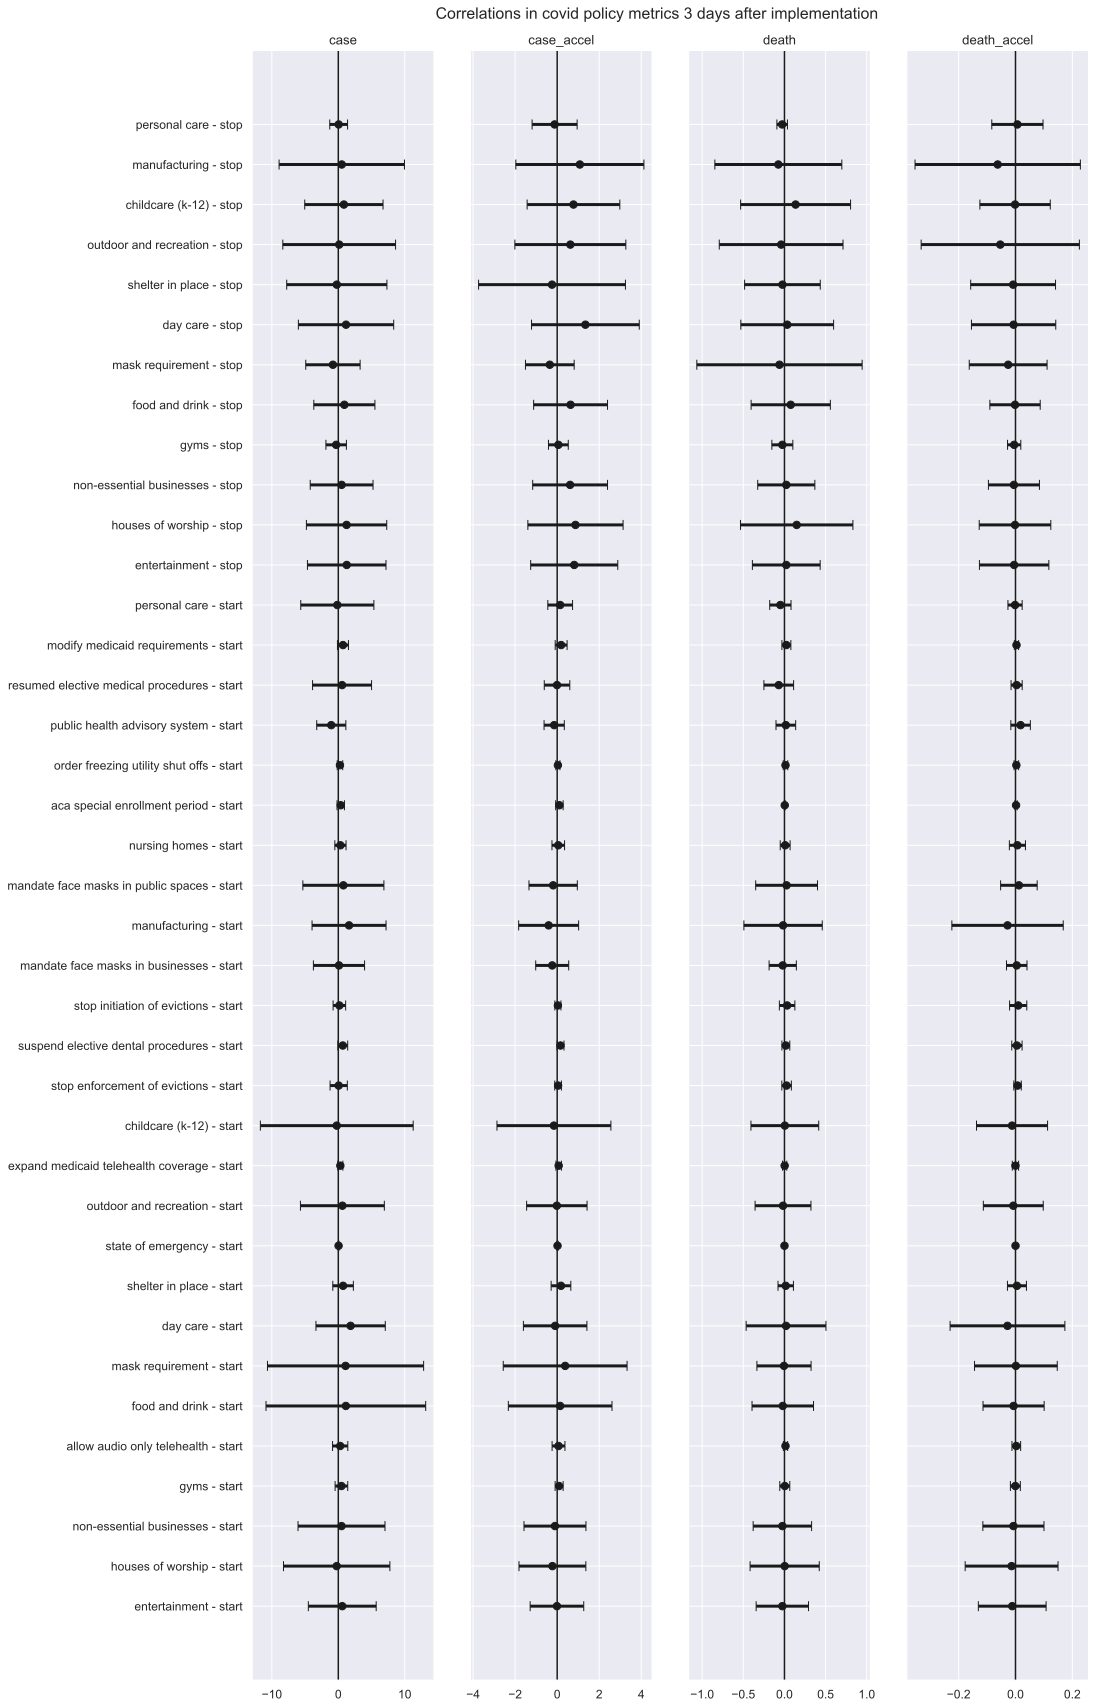

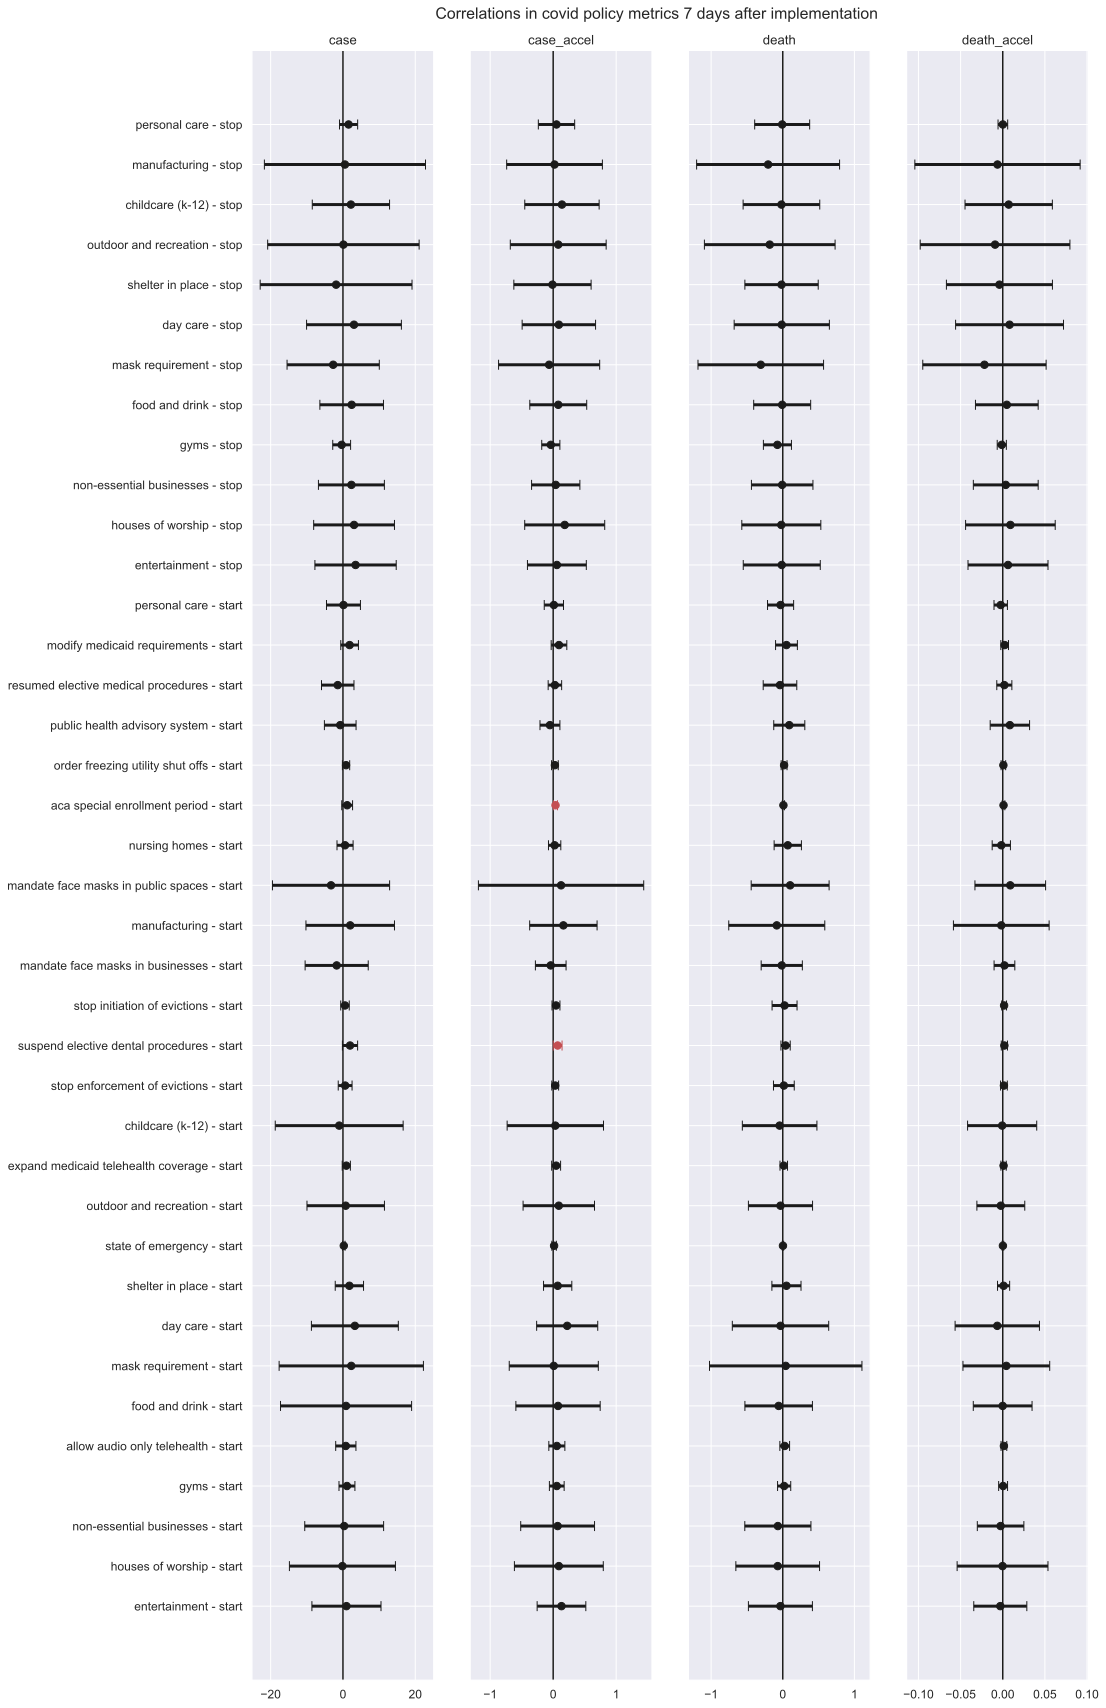

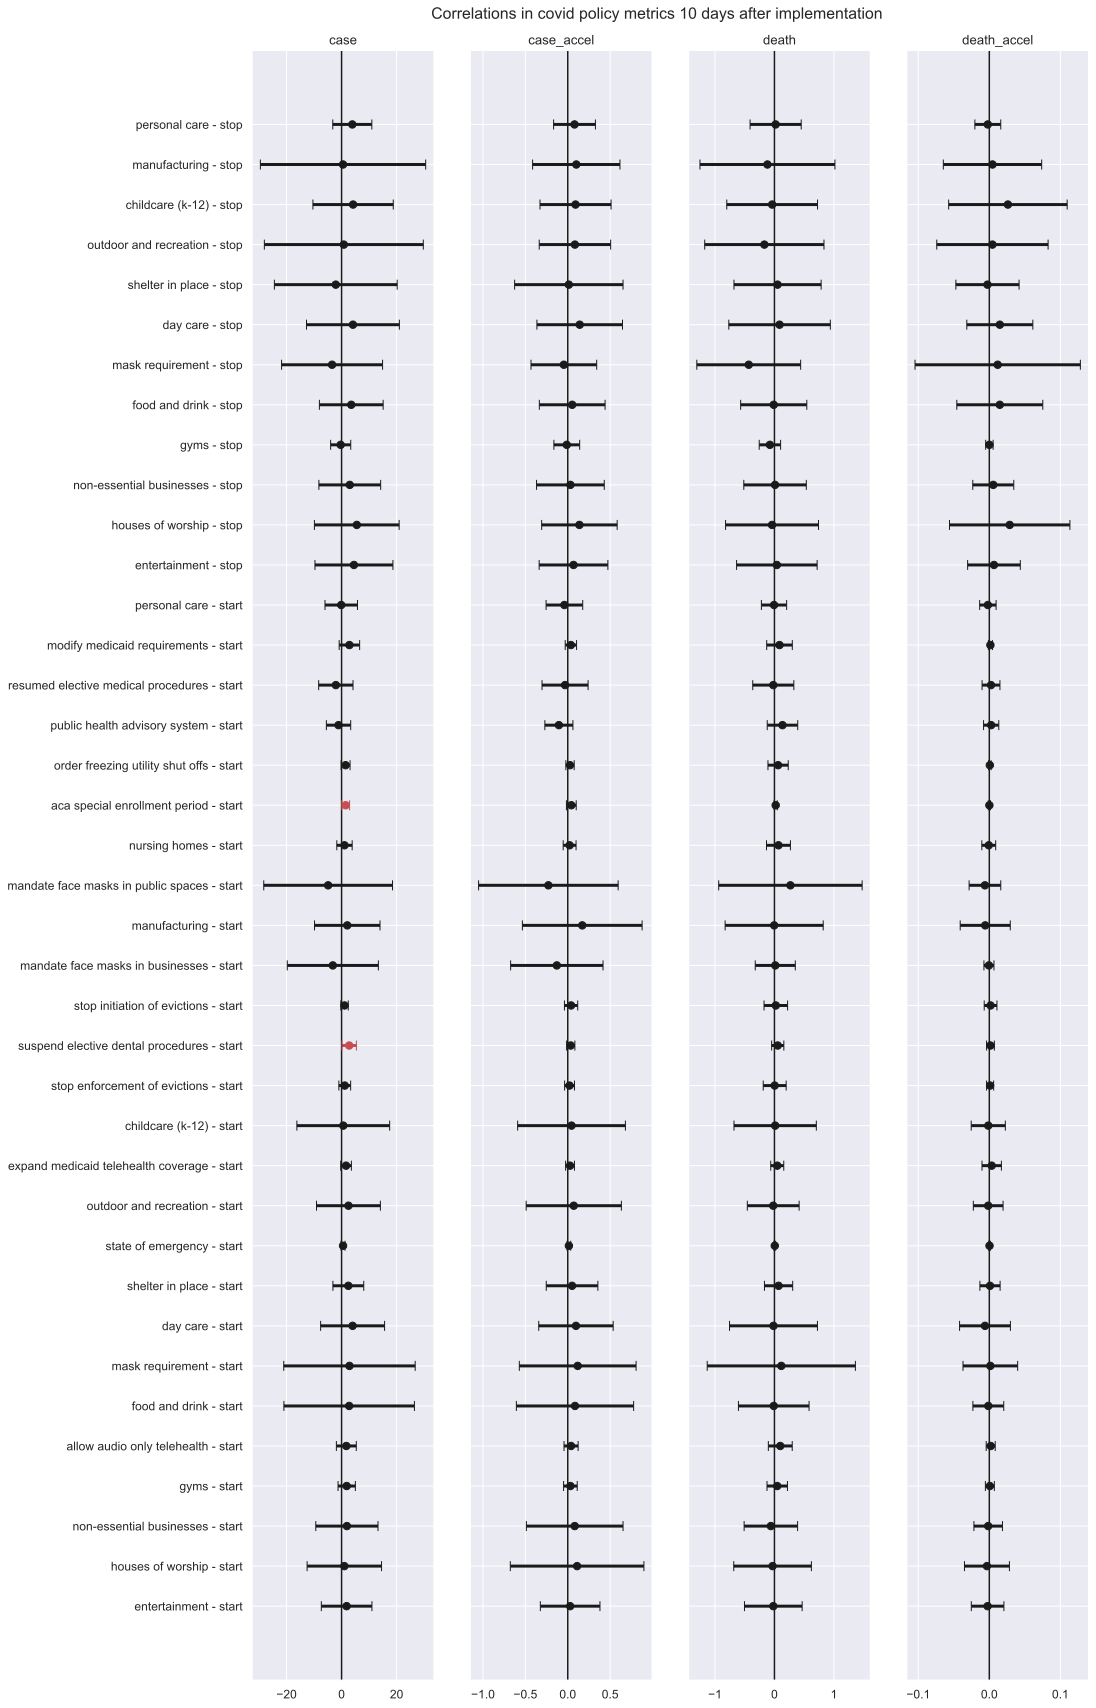

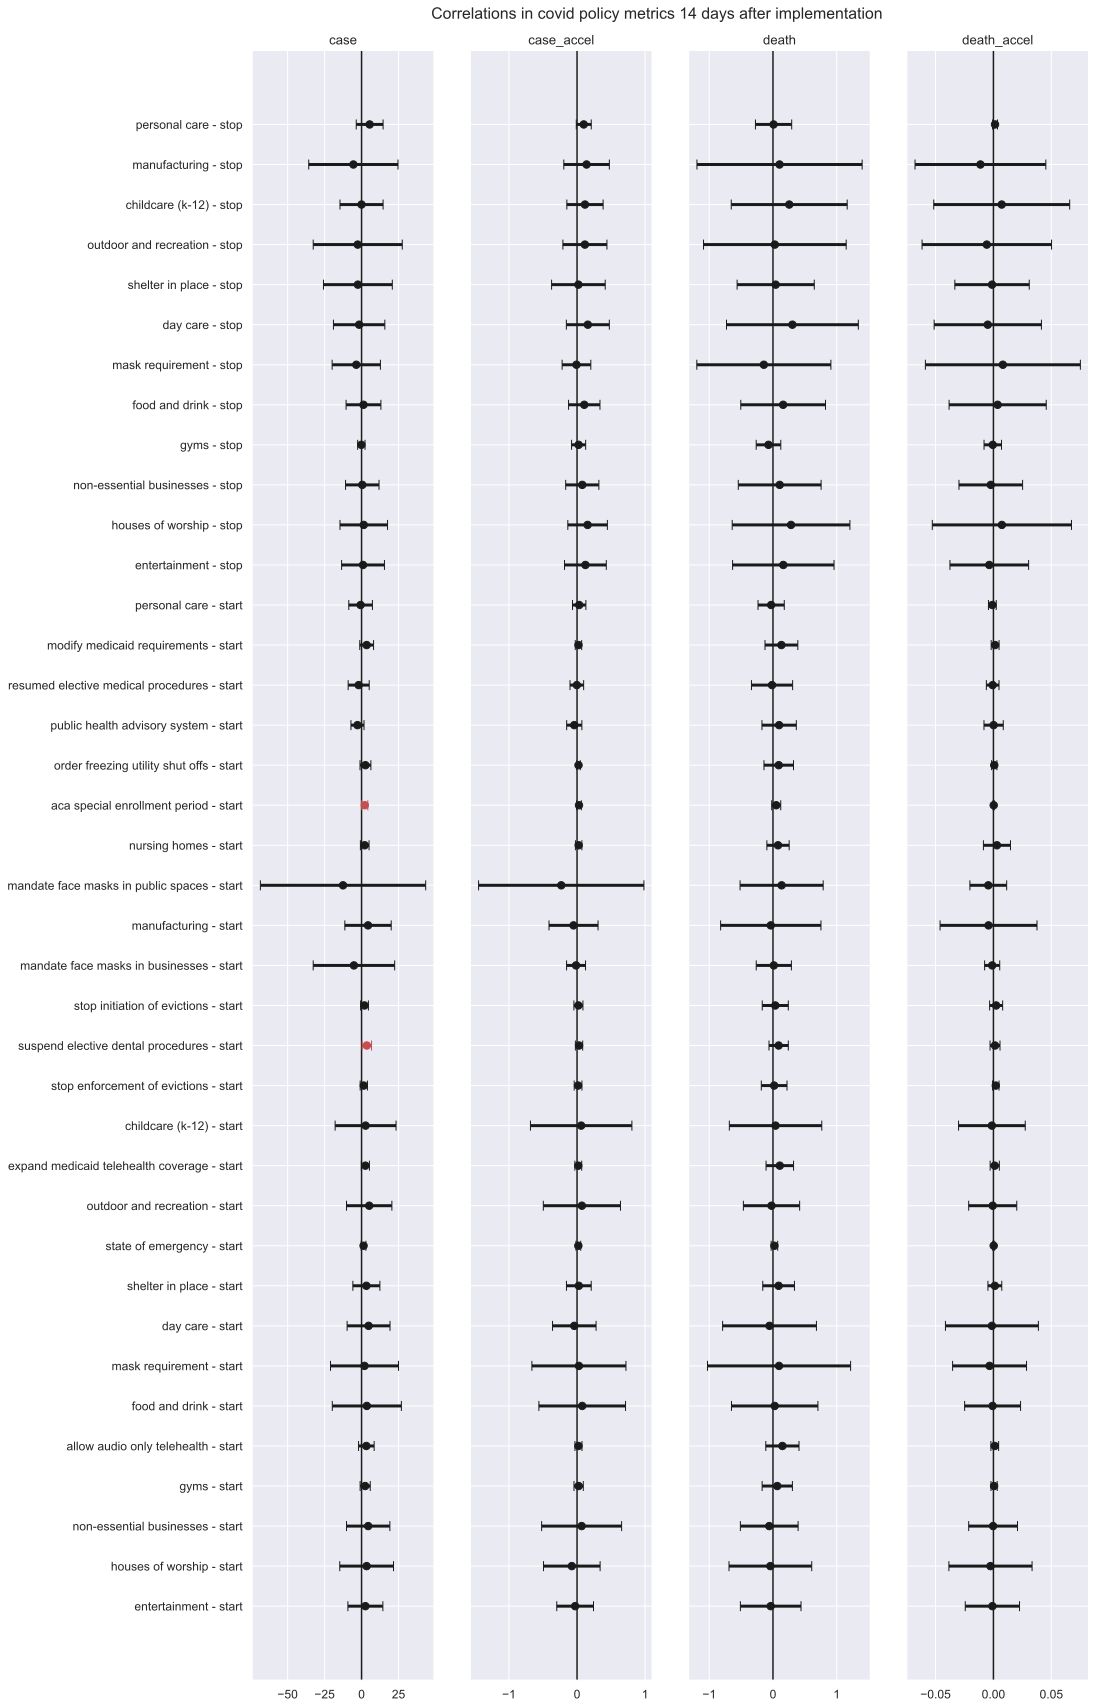

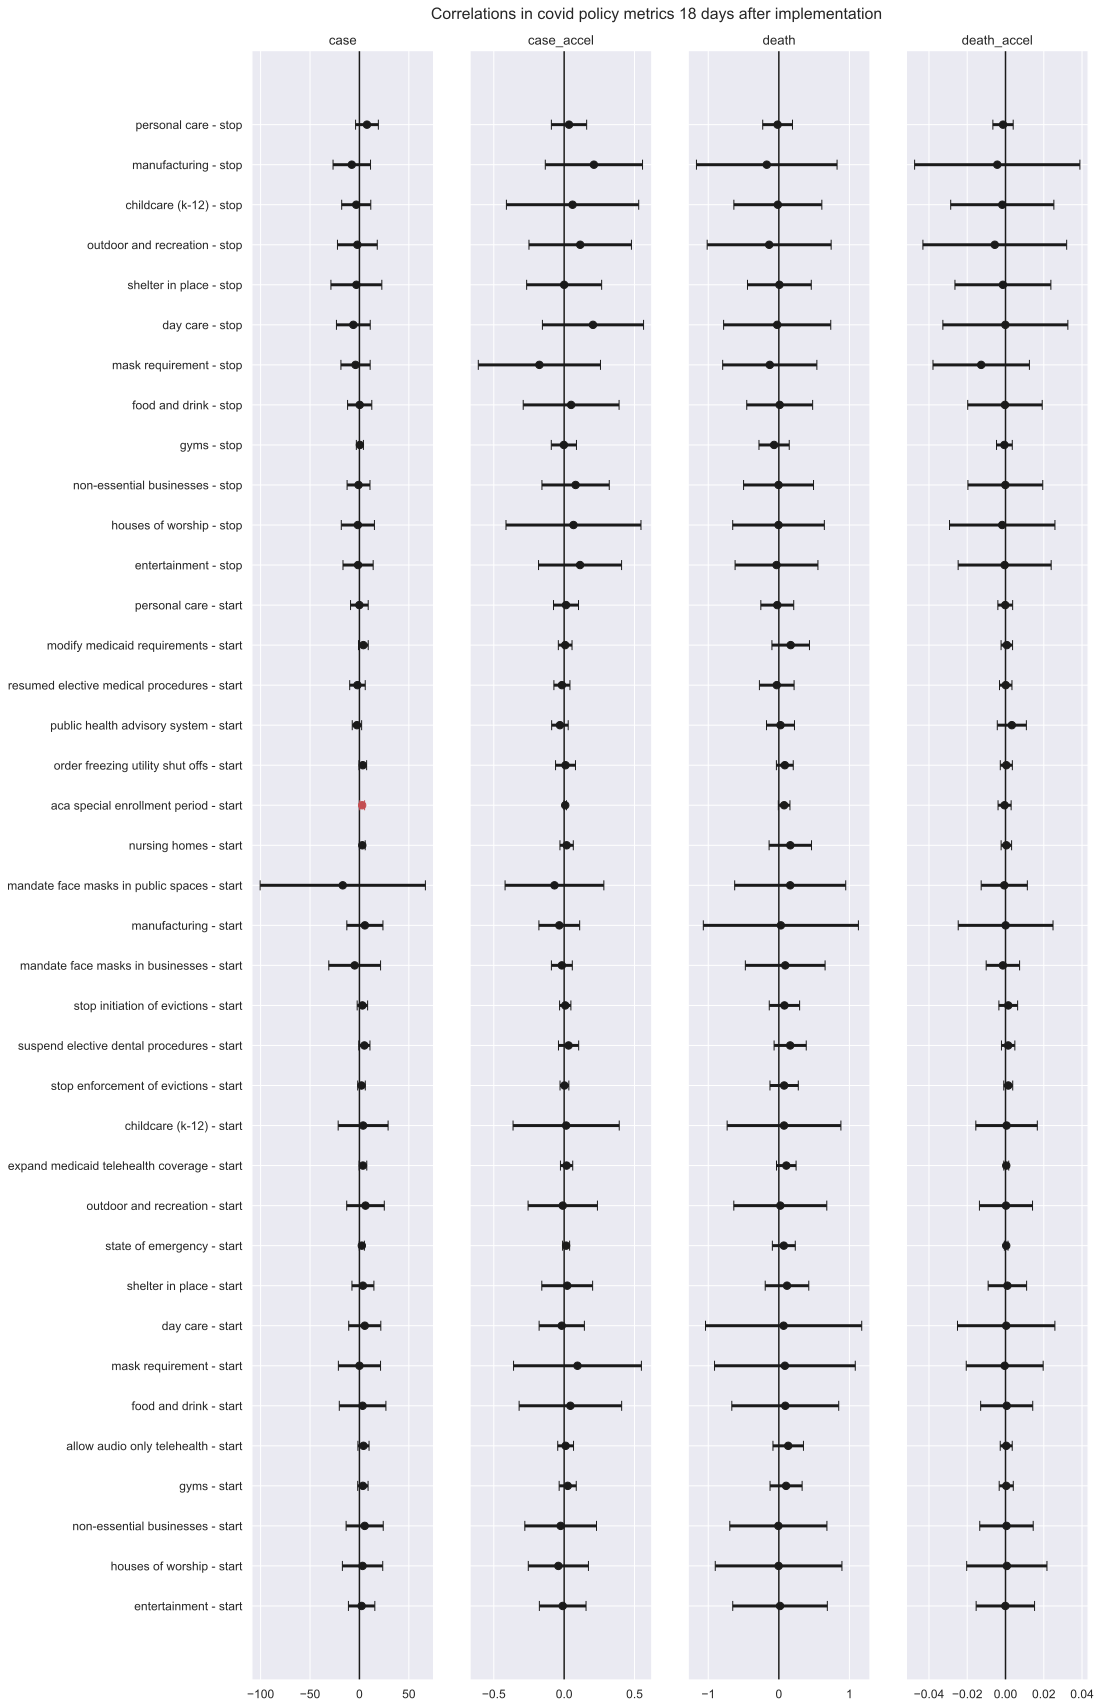

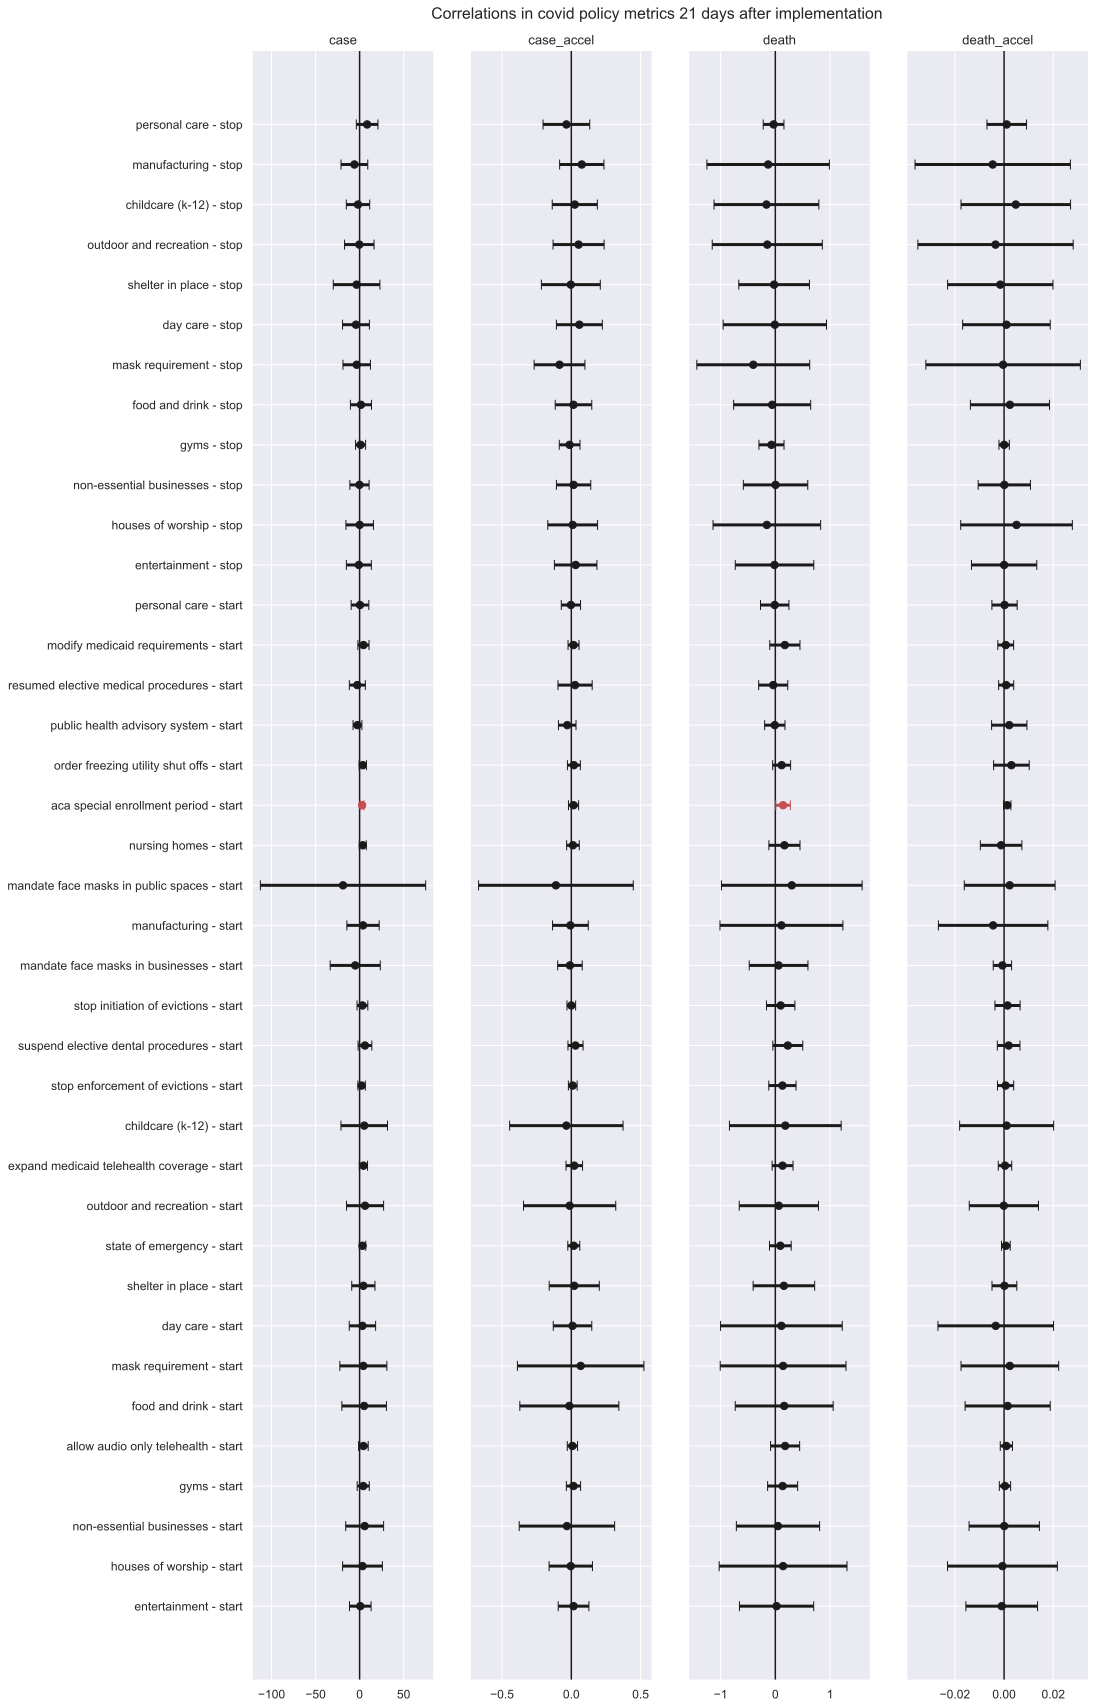

In [203]:
days = [3, 7, 10, 14, 18, 21, 28, 35]
for day in days: 
    eval_delta_stats(calc_delta_stats(deltas=calculate_deltas(measure_period=day), measure_period=day), num_days=day)

# 3.3 <a id='3.3'>Discussion</a>
[back to top](#top)<br>

Evidently, the only areas where a a policy is more than 1 standard deviation away from 0 is the average increase in cases associated with 'suspend elective dental procedures - start' and 'aca special enrollment period - start'.  

It is vitally important to remember the correlation =/= causation. For example, even though closing houses of worship is correlated with the largest decrease in case acceleration, the does not mean that closing houses of worship CAUSED the largest decrease in case acceleration. There are many, many variables involved. 

# 3.4 <a id='3.4'>linear regression</a> (in development)
[back to top](#top)<br>

In the next version of this project, I will introduce a multilinear regression model to properly estimate the relative impacts of various policy implementations on the pandemic. To view the the progress of the update, see [this notebook]( on the dev2 branch

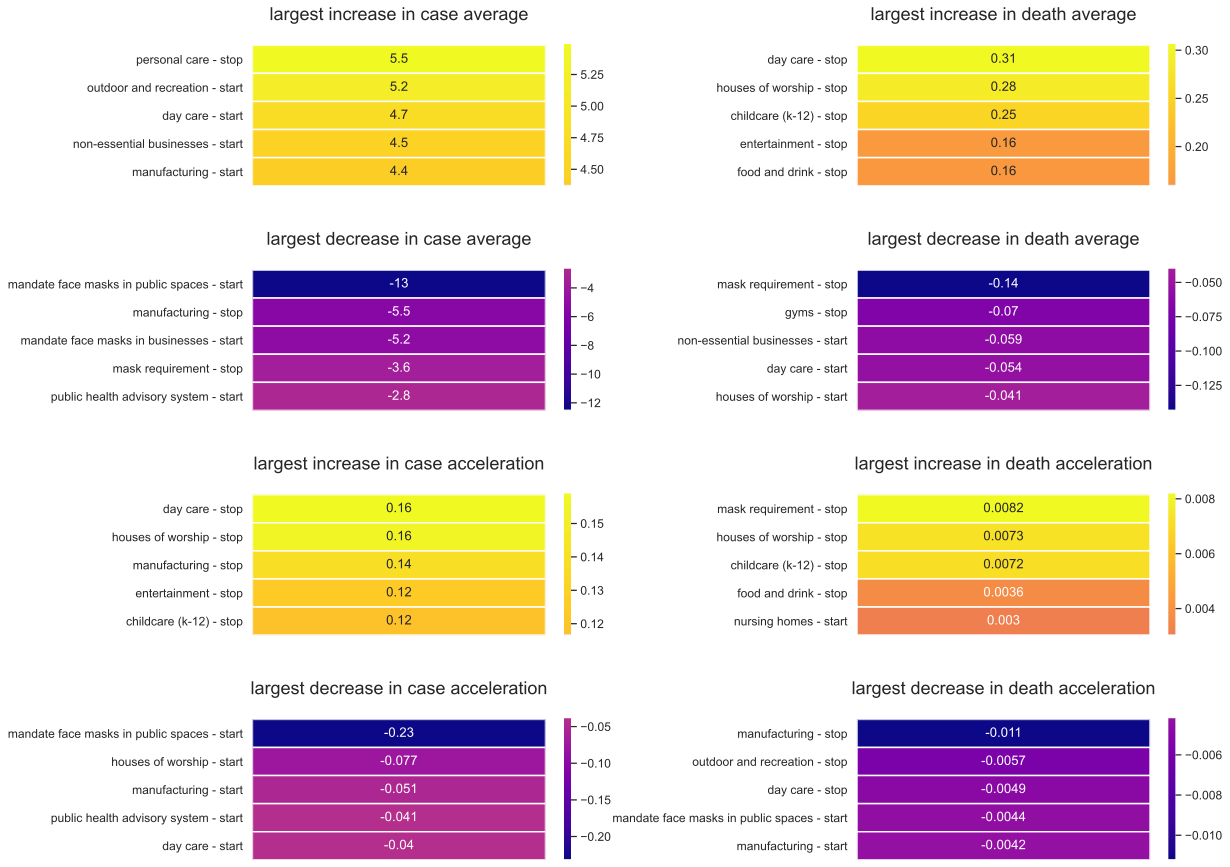

In [198]:
# Filter the most extremem of each relation (largest increase / decrease in number / acceleration of new cases / deaths). 
dfs_case = [delta_stats.sort_values(by="case_avg", ascending=False)[["case_avg"]].head(),
            delta_stats.sort_values(by="case_avg", ascending=True)["case_avg"].head(), 
            delta_stats.sort_values(by="case_accel_avg", ascending=False)["case_accel_avg"].head(),
            delta_stats.sort_values(by="case_accel_avg", ascending=True)["case_accel_avg"].head()
           ]

dfs_death = [delta_stats.sort_values(by="death_avg", ascending=False)["death_avg"].head(),
             delta_stats.sort_values(by="death_avg", ascending=True)["death_avg"].head(), 
             delta_stats.sort_values(by="death_accel_avg", ascending=False)["death_accel_avg"].head(),
             delta_stats.sort_values(by="death_accel_avg", ascending=True)["death_accel_avg"].head()
            ]


# Generate arrays for titles. 
titles_case = [
    "largest increase in case average\n",
    "largest decrease in case average\n",
    "largest increase in case acceleration\n",
    "largest decrease in case acceleration\n", 
]

titles_death = [
    "largest increase in death average\n", 
    "largest decrease in death average\n", 
    "largest increase in death acceleration\n", 
    "largest decrease in death acceleration\n"
]

# Set up figures. 
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=[15, 15])
plt.subplots_adjust(hspace=0.6, wspace=0.65, left=0)
sns.set(font_scale=1.1)

# Make the plots. 
for i in range(len(ax[:,0])): 
        
        # Plot heatmap for cases. 
        handles = sns.heatmap(np.asarray(dfs_case[i]).reshape(5,1), 
                              yticklabels=dfs_case[i].index, 
                              xticklabels="",
                              ax=ax[i,0], 
                              cbar=True, 
                              annot=True, 
                              cmap="plasma",
                              center = 0, 
                              linewidths=1.5
                             )
        ax[i,0].set_title(titles_case[i], fontsize=18)
        
        # Plot heatmap for deaths. 
        handles = sns.heatmap(np.asarray(dfs_death[i]).reshape(5,1), 
                              yticklabels=dfs_death[i].index,
                              xticklabels="", 
                              ax=ax[i,1], 
                              cbar=True, 
                              annot=True, 
                              cmap="plasma", 
                              center = 0,
                              linewidths=1.5
                             )
        ax[i,1].set_title(titles_death[i], fontsize=18)

# 4. <a id='4'>Conclusion</a>
[back to top](#top)<br>

To summarize, we cleaned 2 datasets: one on the covid-19 case and death numbers and another on the policy data. We plotted the case data at the country and state level and correlated those with policy implementations. Finally, we more elegantly correlated the policies with case data by aggregating all the policy implementations to get a measure on the change in cases and deaths, as well as how fast those case and death numbers are changing (acceleration). 